In [2]:
# 바운딩 박스
# 모델이 예측한 박스와 실제 박스의 차이 = loss // loss를 줄이는 방식으로 학습
# 
# YOLO는 object detection // [box, class] 
# box = (x, y, w, h) 1x4 // class = ex) (개, 고양이) -> 1x2
# [box, class] = 1x6 = [0:4], [4:] box, class
# label의 [box], [class]와 차이 = loss



In [3]:
# label = [class, x, y, w, h]

In [4]:
import torch
import numpy as np
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cpu"
WEIGHT_DECAY = 0
EPOCHS = 1000

In [6]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1]) # Label 파일 위치
        boxes = []
        with open(label_path) as f:
            for label in f.readlines(): # label 내용 불러오기 
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0]) # 이미지 파일 위치
        image = Image.open(img_path) # 이미지 불러오기
        boxes = torch.tensor(boxes) # box -> tensor 타입으로 바꾸기
        

        if self.transform: # 이미지 사이즈 변경 -> tensor 타입으로 변경
            image, boxes = self.transform(image, boxes) # box 는 없어도 되도록 수정가능

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B)) #7x7x30 <= (class:20+(y/n:1+xywh:4)*2)

        for box in boxes: # boxes: 이미지 마다 Label 이 저장
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # 물체가 있는 cell 찾기
            i = int(self.S * x)
            j = int(self.S * y)

            x_cell = self.S * x - i
            y_cell = self.S * y - j

            if label_matrix[i, j, 20] == 0:

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width, height]
                )
                
                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        for box in boxes:  # boxes: 이미지 마다 Label 이 저장
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i = int(self.S * x)
            j = int(self.S * y)

            x_cell = self.S * x - i
            y_cell = self.S * y - j

            if label_matrix[i, j, 20] == 0:
                box_coordinates = torch.tensor([x_cell, y_cell, width, height])

                label_matrix[i, j, 20] = 1
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [7]:
BATCH_SIZE = 32

ANNOT_DIR = "./30examples.csv"
IMG_DIR = "./images"
LABEL_DIR = "./labels"

train_dataset = VOCDataset(
    csv_file = ANNOT_DIR,
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR,
    transform = transform,
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False, 
)

In [8]:
img, box = next(iter(train_loader))

In [9]:
def imgshow(img, box):
    inx = torch.where(box[..., 20].view(-1)==1)[0]
    index = []
    for i in inx:
        index.append(divmod(i.numpy(), 7))  # 몇 번째 cell에 물체가 있는지 구함

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img.permute(1, 2, 0)) # tensor : channel

    for _, (i, j) in enumerate(index):
        dx, dy, dw, dh = box[i, j, 21:25]

        x = dx*64 + i*64
        y = dy*64 + j*64
        w = int(dw*448)
        h = int(dh*448)

        xx = np.max((int(x-w/2), 0))
        yy = np.max((int(y-h/2), 0))

        ax.add_patch(
            patches.Circle(
                (x, y),
                edgecolor = 'red',
                fill = False
            )
        )

        ax.add_patch(
            patches.Rectangle(
                (xx, yy),
                w,h,
                edgecolor = 'red',
                fill = False
            )
        )

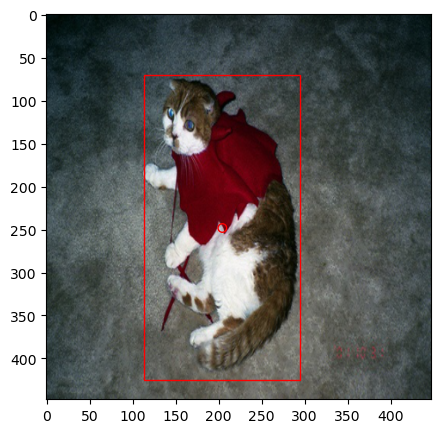

In [10]:
imgshow(img[10], box[10])

In [11]:
# model

import torch
import torch.nn as nn

# CNN architecture -> named 'Darknet'

architecture_config = [
    # kernel_size, filters, stride, padding
    (7, 64, 2, 3),
    # M is simply maxpooling with stride = 2 and kernel = 2
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024 ,1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


# Convoution -> BatchNorm -> LeakyReLU 블록 정의
class CBABlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CBABlock, self).__init__()
        # Convolution Layer
        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        # BatchNorm Layer
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # LeakyReLU Layer
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        # Feedforward : Conv -> BatchNorm -> LeakyReLU
        return self.leakyrelu(self.batchnorm(self.conv(x)))


# YOLOv1 모델 정의
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)      # DarkNet53
        self.fcs = self._create_fcs(**kwargs)    # Fully Connected Networks
        
    def forward(self, x):
        x = self.darknet(x) # CNN
        return self.fcs(torch.flatten(x, start_dim = 1))    # FNC

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CBABlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3], 
                    )
                ]
                in_channels = x[1]

            # MaxPooling Layer
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

            # 반복적인 컨볼루션 블록
            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CBABlock(
                            in_channels,
                            conv1[1],
                            kernel_size = conv1[0],
                            stride = conv1[2],
                            padding = conv1[3],
                        )
                    ]
                    layers += [
                        CBABlock(
                            conv1[1],
                            conv2[1],
                            kernel_size = conv2[0],
                            stride = conv2[2],
                            padding = conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # 원본 논문에서는 다음과 같이 정의됨:
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))
        
        return nn.Sequential(
            nn.Flatten(),       # 평탄화
            nn.Linear(1024 * S * S, 496),   # 입력 크기를 496으로 줄임
            nn.Dropout(0.0),    # 드롭아웃
            nn.LeakyReLU(0.1),  # 활성화 함수
            nn.Linear(496, S * S * (C + B * 5)),    # 최종 출력 크기
        )
    

In [12]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):
    if box_format == "midpoint":
        # 예측 박스의 좌표 계산 (중심점(x, y), w, h)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2 # x - w/2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2 # y - h/2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2 # x + w/2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2 # y + h/2

        # 실제 라벨 박스의 좌표 계산 (중심점(x, y), w, h)
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2 # x - w/2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2 # y - h/2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2 # x + w/2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2 # y + h/2

    if box_format == "corners":
        # 예측 박스의 좌표 계산 (LeftTop, RightBottom)
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        # 실제 라벨 박스의 좌표 계산 (LeftTop, RightBottom)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # 교차 영역의 좌표 계산
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.max(box1_x2, box2_x2)
    y2 = torch.max(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # 각 박스의 영역 계산
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # IoU 계산
    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        # self.mse = mseloss(a, b)
        # def mseloss(a, b):
        #   return torch.mean((a-b) ** 2)

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5     # no object
        self.lambda_coord = 5       # coordinate

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S*(C+B*5)) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)     # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object  in them to 0. We only take out one of the two Predictions, 
        # which is the one with highest IoU calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]   # for label

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])   # for label

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim = -2),
            torch.flatten(box_targets, end_dim = -2),
        )

        # ======================== #
        #    FOR OBJECT LOSS       #
        # ======================== #

        # pred_box is confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),       # exist box : 0 or 1
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================== #
        #  FOR NO OBJECT LOSS      #
        # ======================== #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim = 1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim = 1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim = 1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim = 1),
        )

        # ======================== #
        #    FOR CLASS LOSS        #
        # ======================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [14]:
import torch.optim as optim

model = Yolov1(split_size = 7, num_boxes = 2, num_classes = 20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

In [15]:
from tqdm import tqdm
model.train()

for epoch in range(EPOCHS):

    mean_loss = []

    for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Mean Loss was {sum(mean_loss)/len(mean_loss)}')

100%|██████████| 1/1 [00:22<00:00, 22.58s/it]


Mean Loss was 803.6743774414062


100%|██████████| 1/1 [00:24<00:00, 24.25s/it]


Mean Loss was 736.867431640625


100%|██████████| 1/1 [00:20<00:00, 20.99s/it]


Mean Loss was 476.23553466796875


  0%|          | 0/1 [00:20<?, ?it/s]


KeyboardInterrupt: 

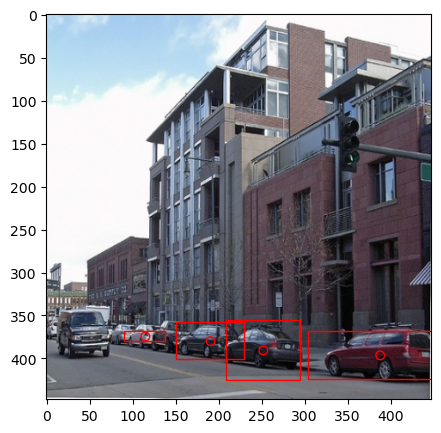

In [ ]:
model.eval()

model.to(DEVICE)
pred = model(x)
pred = pred.view(-1, 7, 7, 30)

inx = 3
pred[inx, ..., 20] = (pred[inx, ..., 20] > 0.60) * 1        # 논문에서는 non-max suppresion 사용

imgshow(x[inx].detach().cpu(), pred[inx].detach().cpu())

In [ ]:
pred = model(x)
pred = pred.view(-1, 7, 7, 30).detach().cpu()

pred[1, ..., 20]

tensor([[ 0.0436, -0.0177,  0.0523,  0.0225, -0.0406, -0.0508, -0.0405],
        [-0.0054,  0.0051, -0.0758,  0.0379,  0.0465,  0.0902, -0.0117],
        [-0.0407,  0.0114,  0.0370, -0.0150,  0.0208,  0.0427, -0.0489],
        [-0.0611,  0.0056,  0.0513,  0.9729,  0.0267,  0.0137,  0.0119],
        [ 0.0710,  0.0623,  0.1034,  0.0054, -0.0226,  0.0767,  0.0425],
        [-0.0198, -0.0721, -0.0218, -0.0175,  0.0208,  0.0354,  0.0167],
        [-0.0576,  0.0060,  0.0075,  0.0368,  0.0862, -0.0404,  0.0278]])